- Kalman

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('classic')

In [2]:
data = pd.read_excel(r'..\Data\front.xlsx')

In [3]:
data.head(4)

,Accel x (m/s^2),Accel y (m/s^2),Accel z (m/s^2),w_x (rad/s),w_y (rad/s),w_z (rad/s),Temp (Â°C)
0,2.30,-0.71,15.91,1.00,0.40,1.80,24.57
1,1.66,-1.17,17.64,0.80,0.44,1.32,24.57
2,1.71,-1.22,17.68,1.16,0.09,0.93,24.57
3,2.04,-0.79,16.59,1.22,-0.21,0.53,24.57


In [12]:
'''
    Se crea el vector de tiempo asociado a la tasa de muestreo del sensor
'''
data_len = len(data) 
T = 1 / 10 
total_time = T * data_len 
t = np.linspace(0, total_time, data_len)
data['time'] = t

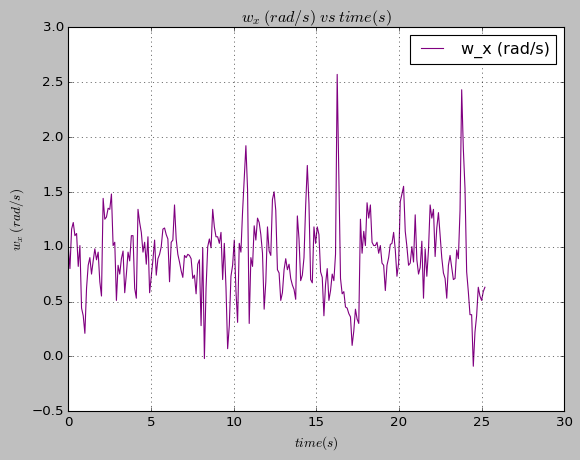

In [20]:
data.plot(x='time', y='w_x (rad/s)', color='purple')
plt.grid()
plt.ylabel(r'$w_{x}\;(rad/s)$')
plt.xlabel('$time (s)$')
plt.title(r'$w_{x}\;(rad/s)\; vs \; time(s)$')
plt.show()

In [101]:
# asumiendo el angulo inicial como 
data['angle_x'] = np.arctan(data['Accel x (m/s^2)'] / ( (data['Accel y (m/s^2)'])**2 + (data['Accel z (m/s^2)'])**2 )**( 1 / 2))
data['angle_x (degrees)'] = np.rad2deg(np.arctan(data['Accel x (m/s^2)'] / ( (data['Accel y (m/s^2)'])**2 + (data['Accel z (m/s^2)'])**2 )**( 1 / 2)))

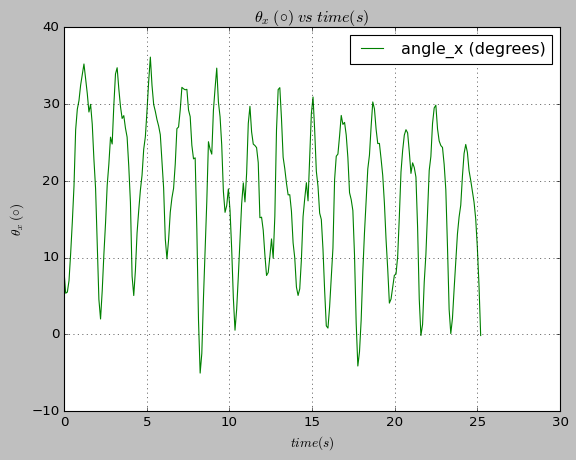

In [39]:
data.plot(x='time', y='angle_x (degrees)', color='g')
plt.grid()
plt.ylabel(r'$\theta_{x}\;(\circ)$')
plt.xlabel('$time (s)$')
plt.title(r'$\theta_{x}\;(\circ)\; vs \; time(s)$')
plt.show()

- Complementario

In [51]:
print(data.shape[0])

252


In [112]:
angle_x_prev = 0
valores = [[0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
for mu, lamb in valores:
    name = 'angle_x_fc_{:.1f}'.format(mu)
    data[name] = np.zeros(data.shape[0])    
    for i in range(data.shape[0]):
        data[name].iloc[i] = mu * (angle_x_prev + np.rad2deg(data['w_x (rad/s)'].iloc[i]* (1 / 10))) + lamb*np.rad2deg(np.arctan(data['Accel x (m/s^2)'].iloc[i] / ( (data['Accel y (m/s^2)'].iloc[i])**2 + (data['Accel z (m/s^2)'].iloc[i])**2 )**( 1 / 2)))
        angle_x_prev = data['angle_x_fc'].iloc[i]  

In [113]:
data.head(0)

,Accel x (m/s^2),Accel y (m/s^2),Accel z (m/s^2),w_x (rad/s),w_y (rad/s),w_z (rad/s),Temp (Â°C),time,angle_x (degrees),angle_x_fc,angle_x_fc_0.2,angle_x_fc_0.3,angle_x_fc_0.4,angle_x_fc_0.5,angle_x


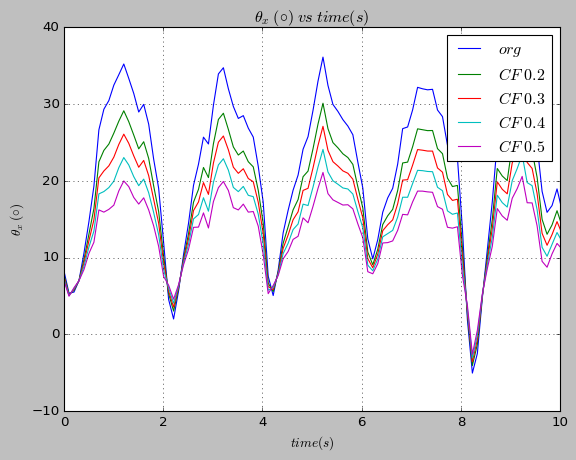

In [114]:
compare_x_angle = data['angle_x (degrees)'].to_numpy()
counter = 0
compare_x_angle_fc = np.zeros([data_len,len(valores)])
for mu in [sub[0] for sub in valores]:
    name = 'angle_x_fc_{:.1f}'.format(mu)
    compare_x_angle_fc[:, counter] = data[name].to_numpy()
    counter += 1

plt.plot(t, compare_x_angle, label=r'$org$')
plt.plot(t, compare_x_angle_fc[:,0], label=r'$CF\;0.2$')
plt.plot(t, compare_x_angle_fc[:,1], label=r'$CF\;0.3$')
plt.plot(t, compare_x_angle_fc[:,2], label=r'$CF\;0.4$')
plt.plot(t, compare_x_angle_fc[:,3], label=r'$CF\;0.5$')
plt.grid()
plt.xlim([0,10])
plt.legend()
plt.ylabel(r'$\theta_{x}\;(\circ)$')
plt.xlabel('$time (s)$')
plt.title(r'$\theta_{x}\;(\circ)\; vs \; time(s)$')
plt.show()

- Test

In [109]:
import numpy as np

bias = 0
R_measure = 0.15  # ruido medido
Q_angle = 0.1     # ruido procesado
Q_bias = 0.3
R_measure = 1     # ruido medido

P = np.zeros((2, 2))
K = np.zeros(2)
angle = 0

def getAngle(pitch, gyrorate, dt):

    global bias
    global angle
    global P

    rate = gyrorate - bias
    angle += dt * rate

    P[0, 0] += dt * (dt * P[1, 1] - P[0, 1] - P[1, 0] + Q_angle)
    P[0, 1] -= dt * P[1, 1]
    P[1, 0] -= dt * P[1, 1]
    P[1, 1] += Q_bias * dt

    S = P[0, 0] + R_measure
    K[0] = P[0, 0] / S
    K[1] = P[1, 0] / S
    y = pitch - angle

    angle += K[0] * y
    bias += K[1] * y

    P -= np.outer(K, P[0])

    return angle


In [116]:
pitch_data = data['angle_x']
gyrorate_data = data['w_x (rad/s)']
dt_data = (1 / 10)

angle_results = []

for pitch, gyrorate in zip(pitch_data, gyrorate_data):
    angle_result = getAngle(pitch, gyrorate, dt_data)
    angle_results.append(angle_result)

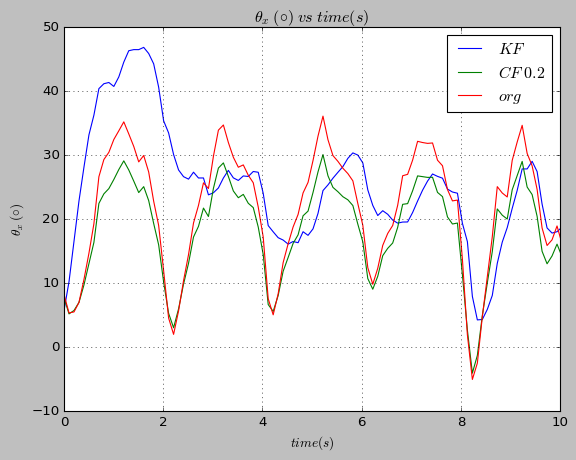

In [120]:
plt.plot(t, np.rad2deg(angle_results), label=r'$KF$')
plt.plot(t, compare_x_angle_fc[:,0], label=r'$CF\;0.2$')
plt.plot(t, compare_x_angle, label=r'$org$')
plt.grid()
plt.xlim([0,10])
plt.legend()
plt.ylabel(r'$\theta_{x}\;(\circ)$')
plt.xlabel('$time (s)$')
plt.title(r'$\theta_{x}\;(\circ)\; vs \; time(s)$')
plt.show()

- PCA

In [ ]:
# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Carga y preprocesamiento de datos
data = pd.read_excel(r'..\Data\front.xlsx')
features = data.columns[:-1]
X = data[features]
X = StandardScaler().fit_transform(X)

In [ ]:
# Cálculo de la media y la matriz de covarianza
mean_vec = np.mean(X, axis=0)
cov_mat = np.cov(X.T)

In [ ]:
# Cálculo de los eigenvalores y eigenvectores
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

In [ ]:
# Selección de componentes principales
# Ordenar los eigenvalores y eigenvectores
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

# Seleccionar las k componentes principales
k = 2
W = np.hstack([eigen_pairs[i][1].reshape(-1,1) for i in range(k)])

In [ ]:
# Proyección de los datos a las componentes principales
X_pca = X.dot(W)

In [ ]:
# Visualización de resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección de los datos en las primeras dos componentes principales')
plt.show()

- FFT

In [14]:
%reset

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.fft import fft, ifft, fftfreq
plt.style.use('classic')

In [18]:
'''
The acelerations are in m/s and the gyros in rad/s
'''
data = pd.read_csv('..\Data\slicer.csv') 
data.head(3)

,Accel x (m/s^2),Accel y (m/s^2),Accel z (m/s^2),w_x (rad/s),w_y (rad/s),w_z (rad/s),Temp (°C)
0,0.68,-2.09,8.36,0.38,0.15,0.38,25.63
1,0.76,-3.11,9.09,-0.01,0.11,-0.36,25.64
2,-0.05,-2.05,9.00,-0.05,-0.21,-0.86,25.64


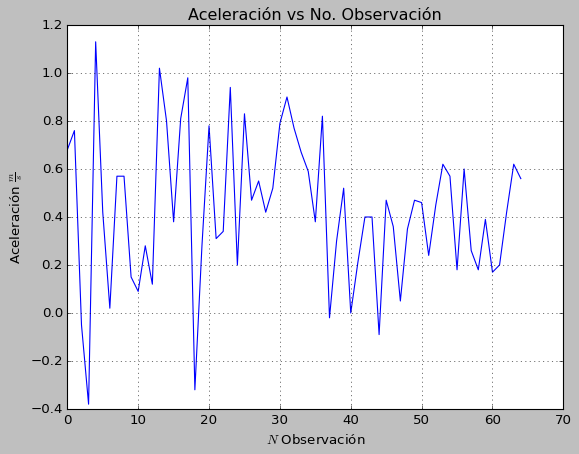

In [21]:
samples = len(data['Accel x (m/s^2)'])
total_time = 0.5*samples
v_sam = np.linspace(0,samples-1,len(data['Accel x (m/s^2)']))
data['Accel x (m/s^2)'].plot()
accx = data['Accel x (m/s^2)'].to_numpy()
plt.xlabel('$N$ Observación')
plt.ylabel(r'Aceleración $\frac{m}{s}$')
plt.title('Aceleración vs No. Observación')
plt.grid()
plt.show()

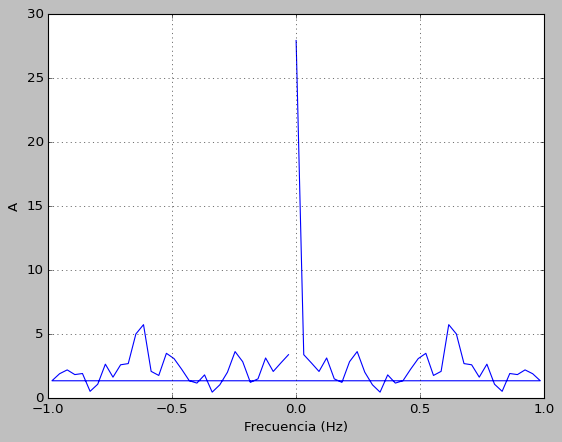

In [22]:
sample_rate = 1/0.5 # Hz 1/0.5s Tasa de muestreo de tarjeta de adquisicion 

yf = fft(accx)
n = np.arange(samples)
T = samples/samples

xf = fftfreq(samples, 1/sample_rate )
plt.plot(xf, np.abs(yf))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('A')
plt.grid()
plt.show()

In [23]:
def RMS(vector):
    sum_squared = sum(i ** 2 for i in vector)
    return sqrt(sum_squared / len(vector))

In [24]:
cero_freq = np.where(xf == 0)[0][0]
print(accx.mean())
medium_value = ifft(yf)[cero_freq]
print(medium_value)

0.42969230769230765
(0.6799999999999999+5.124106267500723e-18j)


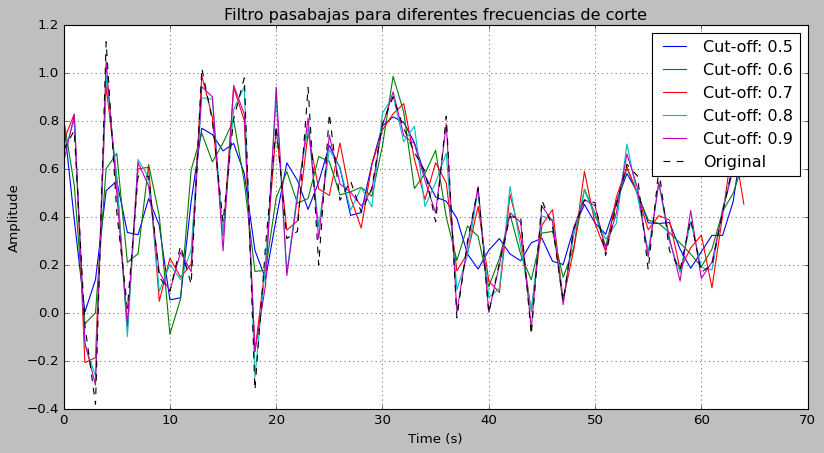

In [27]:
sig_fft_accx = yf.copy()

cut_offs = np.arange(0.5, 1, 0.1)

plt.figure(figsize=(12, 6))

for cut_off in cut_offs:
    sig_fft_accx_copy = sig_fft_accx.copy()
    
    sig_fft_accx_copy[np.abs(xf) > cut_off] = 0
    
    filtered = np.fft.ifft(sig_fft_accx_copy)
    
    plt.plot(v_sam, filtered.real, label=f'Cut-off: {cut_off:.1f}')

plt.plot(v_sam, accx, linestyle='--', color='black', label='Original')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.title('Filtro pasabajas para diferentes frecuencias de corte')
plt.show()

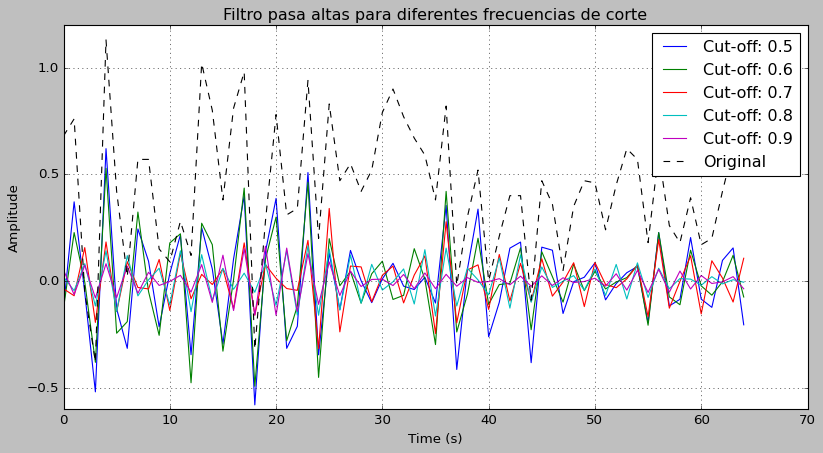

In [28]:
sig_fft_accx = yf.copy()

cut_offs = np.arange(0.5, 1, 0.1)

plt.figure(figsize=(12, 6))

for cut_off in cut_offs:
    sig_fft_accx_copy = sig_fft_accx.copy()
    
    sig_fft_accx_copy[np.abs(xf) < cut_off] = 0

    filtered = np.fft.ifft(sig_fft_accx_copy)

    plt.plot(v_sam, filtered.real, label=f'Cut-off: {cut_off:.1f}')

plt.plot(v_sam, accx, linestyle='--', color='black', label='Original')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.title('Filtro pasa altas para diferentes frecuencias de corte')
plt.show()